# **Master’s in Applied Artificial Intelligence**
## **Course: Artificial Intelligence and Machine Learning**
### Prof. Luis Eduardo Falcón Morales
#### Tecnológico de Monterrey

### **ROC and PR Curves Analysis for Imbalanced Datasets**
##### **Name and student ID:**
* Mario Guillen de la Torre - A01796701

# **Introduction**

This activity is based on the well-known oil-spill dataset.

The dataset contains 50 columns and 937 records. The first 49 columns are metrics derived from satellite images of the ocean, some of which show oil spills from unknown sources. The article details how these features were extracted, but for this activity, it is enough to treat them as numerical values. The last column is binary: 1 indicates a spill in that section of the image, 0 means no spill.

The article related to this dataset is available at the following link:
https://webdocs.cs.ualberta.ca/~holte/Publications/oilspill.pdf

Additional information about many of the metrics used can be found here:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

The geometric mean can be computed from the above metrics, but for practical purposes, we'll use the implementation provided by the "imbalanced-learn" library:

https://glemaitre.github.io/imbalanced-learn/generated/imblearn.metrics.geometric_mean_score.html

In [1]:
# Include all the libraries you consider appropriate:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer,RocCurveDisplay,PrecisionRecallDisplay, classification_report
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.metrics import geometric_mean_score
from numpy import mean, std
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

For the purpose of this activity, we’ll process the data in a standard way so we can focus on the main topics.

In [2]:
path = 'oil_spill.csv'
df = read_csv(path, header=None)    # columns have no names

print('DataFrame Dimensions',df.shape)

# We remove the following columns:
df.drop(22, axis=1, inplace=True)    # This column contains only a constant value.
df.drop(0, axis=1, inplace=True)     # This column contains information about image sections (batches), which we don't need.

df.columns = [i for i in range(df.shape[1])]   # We rename the columns to use numerical indexes

# We partition the input data (X) and output data (y):
X,y = df.iloc[:,:-1], df.iloc[:,-1]

Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.12, stratify=y, shuffle=True, random_state=0)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, shuffle=True, random_state=5)
print('\nPartition:')
print('Train: Counts of positive class=%d, Percentage=%.2f%%' % (ytrain.sum(), 100*(ytrain.sum() / len(ytrain))))
print('Val: Counts of positive class=%d, Percentage=%.2f%%' % (yval.sum(), 100*(yval.sum() / len(yval))))
print('Test: Counts of positive class=%d, Percentage=%.2f%%' % (ytest.sum(), 100*(ytest.sum() / len(ytest))))

DataFrame Dimensions (937, 50)

Partition:
Train: Counts of positive class=29, Percentage=4.40%
Val: Counts of positive class=7, Percentage=4.24%
Test: Counts of positive class=5, Percentage=4.42%


Brief numerical and graphical description of the training set:

In [3]:
Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
0,659.0,344.153263,1.880555e+03,10.00,22.000,65.00,134.500,28526.00
1,659.0,709.286161,5.993162e+02,1.95,97.475,727.45,1242.135,1893.08
2,659.0,867.791608,5.145066e+02,1.00,445.065,791.35,1243.220,2674.16
3,659.0,85.078907,4.573682e+01,0.00,55.000,74.00,119.000,180.00
4,659.0,824339.418816,4.131627e+06,70312.00,127500.000,187500.00,348750.000,71315000.00
5,659.0,42.966449,1.259403e+01,21.24,33.430,39.64,51.975,82.64
6,659.0,9.162307,3.587007e+00,0.83,6.920,8.22,10.755,24.28
7,659.0,4119.098634,8.899523e+03,667.00,1404.750,2167.00,3600.000,160740.00
8,659.0,0.222898,8.984421e-02,0.02,0.170,0.21,0.260,0.74
9,659.0,110.288771,6.272348e+01,47.00,82.950,99.80,115.700,901.70


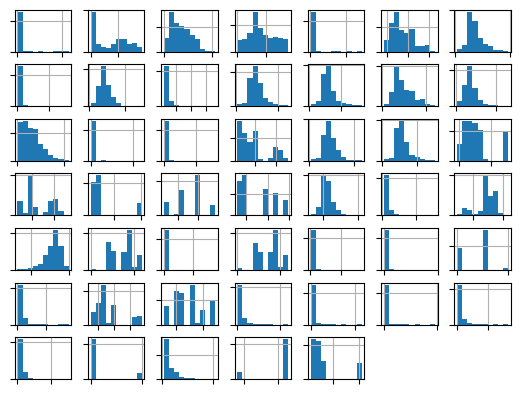

In [4]:
ax = Xtrain.hist()  # Histograms:
# Let's remove all the information from the chart to visualize it more easily:
for axis in ax.flatten():
  axis.set_title('')
  axis.set_xticklabels([])
  axis.set_yticklabels([])
plt.show()

In [5]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 770 to 460
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    int64  
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    int64  
 4   4       659 non-null    float64
 5   5       659 non-null    float64
 6   6       659 non-null    float64
 7   7       659 non-null    float64
 8   8       659 non-null    float64
 9   9       659 non-null    float64
 10  10      659 non-null    float64
 11  11      659 non-null    float64
 12  12      659 non-null    float64
 13  13      659 non-null    float64
 14  14      659 non-null    float64
 15  15      659 non-null    float64
 16  16      659 non-null    float64
 17  17      659 non-null    float64
 18  18      659 non-null    float64
 19  19      659 non-null    float64
 20  20      659 non-null    float64
 21  21      659 non-null    float64
 22  22   

In [6]:
# Code-1:
# We apply the Dummy function:

def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(geometric_mean_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


modeloD = DummyClassifier(strategy='uniform')
scores = evaluate_model(X, y, modeloD)

print('G-mean Metric - Geometric Mean: %.3f (%.3f)' % (mean(scores), std(scores)))

G-mean Metric - Geometric Mean: 0.419 (0.210)


# **Exercise-1**

### **Explain what each line of code in the previous cell named "Code-1" does, as well as the meaning of the output value:**

**+++++++++++ Section to add text begins ++++++++++++++++**

1.   The first line of code defines a function called "evaluate_model" with the input arguments "X", "y", and "model". It can be assumed that X is a matrix or DataFrame with the independent features, "y" is a vector with the dependent variable, and "model" is the model to evaluate.
2.   The second line defines an instance of "RepeatedStratifiedKFold", which will be used as the cross-validation strategy for model evaluation. According to the parameters, ten splits will be used, and the process will be repeated three times. The "random_state=1" ensures the results are reproducible.
3.   The third line defines the scoring function to be used during evaluation; in this case, it will be the geometric mean.
4.   The fourth line executes cross-validation using the strategy defined in the second line, the scoring function from the third line, and the arguments passed to the function.
5.   The fifth line ends the function by returning the evaluation results.
6.   The sixth line creates an instance of a classification model, "DummyClassifier", with a uniform strategy.
7.   The seventh line calls the function defined in the first line, passing "X", "y", and the instance of "DummyClassifier" as the model. This classifier predicts classes randomly with equal probability.
8.   The eighth line prints the results obtained from the function; it calculates the mean of the geometric means obtained from cross-validation and its standard deviation.
9.   Meaning of the output value: We can see that the mean geometric mean obtained is 0.425, which is very low for a classification model. In addition, with a standard deviation of 0.181, this value did not vary much across the cross-validation folds. These values are expected from a "DummyClassifier" instance.

**+++++++++++ Section to add text ends ++++++++++++++**

For the purposes of this activity, we define the following data preprocessing transformations:

In [7]:
# Numerical transformations:

numerical_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='mean')),
                                       ('std_transformer', StandardScaler())])
numerical_pipeline_names = Xtrain.columns

columnsTransformer = ColumnTransformer(transformers = [('num', numerical_pipeline, numerical_pipeline_names)],
                                        remainder='passthrough')

In [8]:
my_metric = make_scorer(geometric_mean_score)  # We define the G-mean metric

Validation Results:
LR
Accuracy: >> 0.953 (0.014)
G-mean: >> 0.764 (0.097)

LASSO
Accuracy: >> 0.968 (0.009)
G-mean: >> 0.689 (0.104)

RIDGE
Accuracy: >> 0.969 (0.011)
G-mean: >> 0.725 (0.108)

EN
Accuracy: >> 0.968 (0.010)
G-mean: >> 0.694 (0.112)

kNN
Accuracy: >> 0.966 (0.005)
G-mean: >> 0.464 (0.204)



C:\Users\mario\AppData\Local\Temp\ipykernel_37276\3309343519.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results1, labels=names,  showmeans=True)


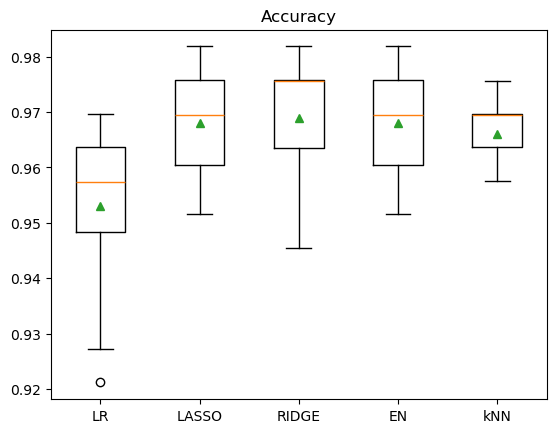

C:\Users\mario\AppData\Local\Temp\ipykernel_37276\3309343519.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results2, labels=names,  showmeans=True)


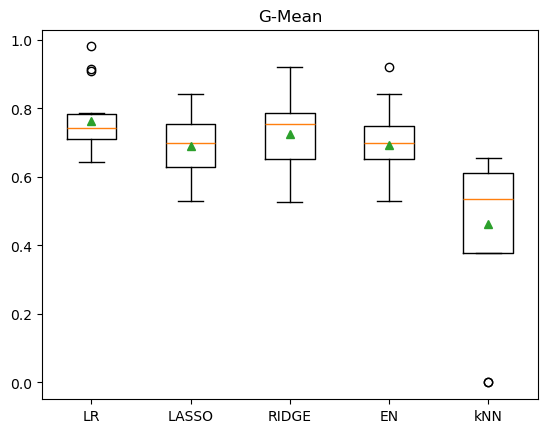

In [9]:
# Code-2:
# ACCURACY & G-mean

def my_models1():
  models, names = list(), list()

  models.append(LogisticRegression(penalty=None,
                                    max_iter=2000,
                                    random_state=1))
  names.append('LR')


  models.append(LogisticRegression(penalty='l1',
                                    solver='liblinear',
                                    max_iter=2000,
                                    random_state=1))
  names.append('LASSO')


  models.append(LogisticRegression(penalty='l2',
                                    max_iter=2000,
                                    random_state=1))
  names.append('RIDGE')

  models.append(LogisticRegression(penalty='elasticnet',
                                    l1_ratio=0.5,
                                    solver='saga',
                                    max_iter=5000,
                                    random_state=1))
  names.append('EN')

  models.append(KNeighborsClassifier(n_neighbors=5))
  names.append('kNN')

  return models, names

# +++++++++++++++++++++++++++++++
models, names = my_models1()
results1, results2 = list(), list()
print('Validation Results:')

for i in range(len(models)):

  pipeline = Pipeline(steps=[('ct',columnsTransformer),('m',models[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'accuracy':'accuracy', 'm_geo':my_metric},
                          cv=cv1)

  results1.append(scores['test_accuracy'])
  results2.append(scores['test_m_geo'])

  print(names[i])
  print('Accuracy: >> %.3f (%.3f)' % (np.nanmean(scores['test_accuracy']), np.nanstd(scores['test_accuracy'])))
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

plt.boxplot(results1, labels=names,  showmeans=True)
plt.title("Accuracy")
plt.show()

plt.boxplot(results2, labels=names,  showmeans=True)
plt.title("G-Mean")
plt.show()


# **Exercise-2**

**Explain why the previous output and graphs help support the decision to use the G-mean metric instead of accuracy in this problem:**

**+++++++++++ Section to add text begins ++++++++++++++++**

In the graphs, it is clearly observed how the accuracy metric gives a much more optimistic view of the results when compared to the geometric mean.

This is because accuracy does not take class balance into account, leading, in cases of imbalanced classes, to the model favoring the correct classification of the majority class. This ensures an accuracy of at least the percentage represented by the majority class, resulting in a deceptively high value without properly classifying the minority class (which is usually the one we want to classify correctly).

To avoid this, it is necessary to use metrics that counteract this imbalance, such as the geometric mean, which calculates the square root of the product of sensitivity and specificity. In this way, if too much preference is given to one variable, the opposing metric approaches zero, effectively penalizing this behavior.


**+++++++++++ Section to add text ends ++++++++++++++**

# **Exercise-3**

**Using only the G-mean metric from now on and similarly to the code in the previous cell called "Code-2," define a function named "mis_models2()" and use it to define the same logistic regression models, but including the argument "class_weight='balanced'". You may vary the other hyperparameters if you consider it appropriate. Include kNN as well, even though it does not have an argument for balancing the output classes.**

Validation Results:
LR
G-mean: >> 0.692 (0.117)

LASSO
G-mean: >> 0.849 (0.069)

RIDGE
G-mean: >> 0.854 (0.062)

EN
G-mean: >> 0.830 (0.063)

kNN
G-mean: >> 0.464 (0.204)



C:\Users\mario\AppData\Local\Temp\ipykernel_37276\3346617565.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results2, labels=names2,  showmeans=True)   # Box plots for a visual comparison of the results.


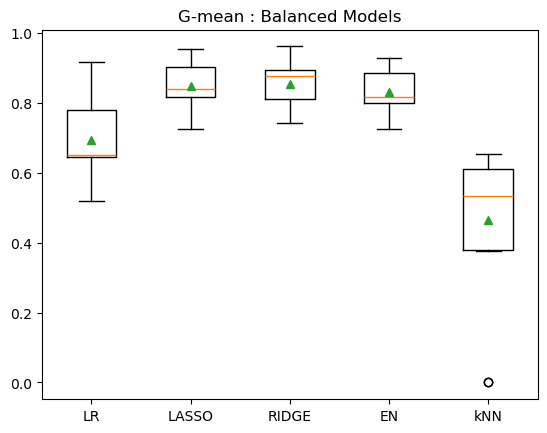

In [10]:
# Balanced cases with Logistic Regression hyperparameter:

# ++++++++++ Section to add your code begins ++++++++++++++++++++++++
def my_models2():
  models, names = list(), list()
  models.append(LogisticRegression(penalty=None,
                                    max_iter=2000,
                                    class_weight = 'balanced',
                                    random_state=1))
  names.append('LR')

  models.append(LogisticRegression(penalty='l1',
                                    solver='liblinear',
                                    max_iter=2000,
                                    class_weight = 'balanced', C=1.,
                                    random_state=1))
  names.append('LASSO')

  models.append(LogisticRegression(penalty='l2',
                                    max_iter=2000,
                                    class_weight = 'balanced',C=.1,
                                    random_state=1))
  names.append('RIDGE')

  models.append(LogisticRegression(penalty='elasticnet',
                                    l1_ratio=0.5,
                                    solver='saga',
                                    max_iter=5000,
                                    class_weight = 'balanced',C=.01,
                                    random_state=1))
  names.append('EN')

  models.append(KNeighborsClassifier(n_neighbors=5))
  names.append('kNN')

  return models, names

models2, names2 = my_models2()
results2 = list()

print('Validation Results:')
for i in range(len(models2)):
  pipeline = Pipeline(steps=[('ct',columnsTransformer),('m',models2[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'m_geo':my_metric},
                          cv=cv1)

  results2.append(scores['test_m_geo'])

  print(names2[i])
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

# ++++++++++ Section to add your code ends ++++++++++++++++++++++++


plt.boxplot(results2, labels=names2,  showmeans=True)   # Box plots for a visual comparison of the results.
plt.title("G-mean : Balanced Models")
plt.show()

# **Exercise-4**

**4a) Select the model you consider the best found so far and use it to obtain the ROC curve and PR curve graphs, as well as the values of their areas under the curve. Continue using the training and validation sets.**

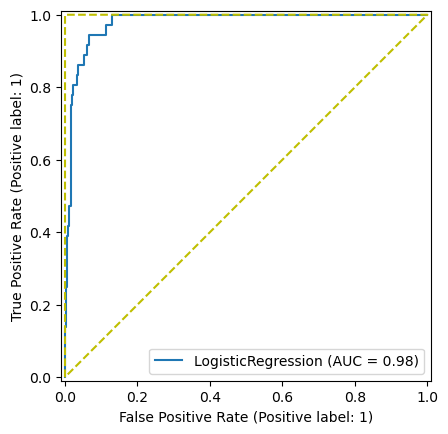

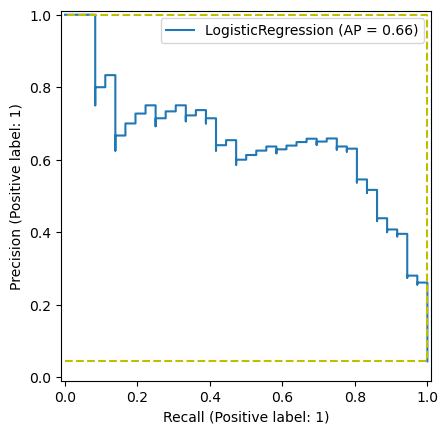

In [11]:
# **+++++++++++ Section to add your code begins ++++++++++++++++**
# NOTE: you can add as many cells as you consider appropriate.
bestModel = LogisticRegression(penalty='l2',
                                    max_iter=2000,
                                    class_weight = 'balanced',C=.1,
                                    random_state=1)
columnsTransformer.fit(Xtrain)
XtrainT = columnsTransformer.transform(Xtrain)
bestModel.fit(X=XtrainT, y=ytrain)

XtvT = columnsTransformer.transform(Xtv)

RocCurveDisplay.from_estimator(bestModel , XtvT, ytv)
plt.plot([0,0,1,0],[0,1,1,0], 'y--')
plt.show()

positive_rate = len(ytrain[ytrain==1]) / len(ytrain)

PrecisionRecallDisplay.from_estimator(bestModel , XtvT, ytv)
plt.plot([0,1,1,0],[positive_rate,positive_rate,1,1], 'y--')
plt.legend(loc="upper right")
plt.show()

# **+++++++++++ Section to add your code ends ++++++++++++++**

### **4b) Include your conclusions from the graphs obtained in the previous section.**

**+++++++++++ Section to add text begins ++++++++++++++++**

It is clear why the ROC curve is not an adequate graph to estimate how good a model is when dealing with an imbalanced class problem. It gives us an AUC of 0.98, which (in a perfectly balanced class situation) would indicate that our model is close to perfect.

In contrast, the PR curve shows that our model has an Average Precision (AP) of 0.66, indicating it is far from perfect. By using a combination of precision and recall, this curve provides a better idea of how our model classifies both classes, not just the majority one.

**+++++++++++ Section to add text ends ++++++++++++++**

# **Exercise-5**

### **Use the test set to evaluate the best model obtained.**

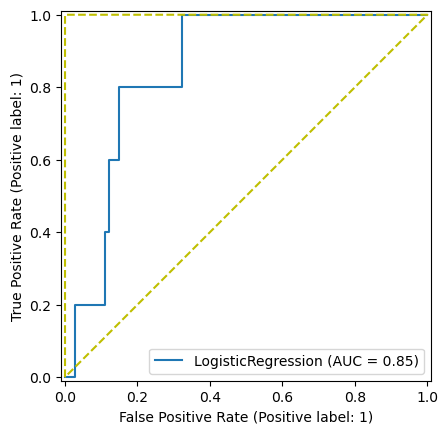

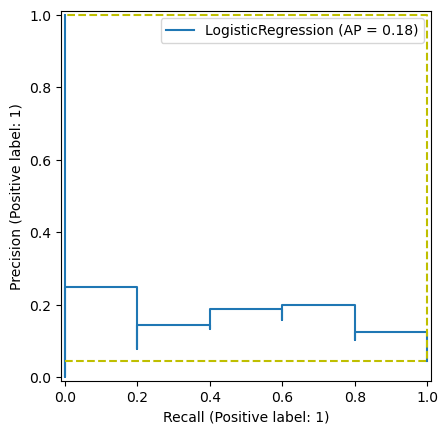

              precision    recall  f1-score   support

          No       0.96      0.91      0.93       108
         Yes       0.09      0.20      0.12         5

    accuracy                           0.88       113
   macro avg       0.53      0.55      0.53       113
weighted avg       0.92      0.88      0.90       113



In [12]:
# **+++++++++++ Section to add your code begins ++++++++++++++++**
# NOTE: you can add as many cells as you consider appropriate.
XTestTransformed = columnsTransformer.transform(Xtest)
yTestPred = bestModel.predict(XTestTransformed)


RocCurveDisplay.from_estimator(bestModel , XTestTransformed, ytest)
plt.plot([0,0,1,0],[0,1,1,0], 'y--')
plt.show()

positive_rate = len(ytest[ytest==1]) / len(ytest)

PrecisionRecallDisplay.from_estimator(bestModel ,XTestTransformed, ytest)
plt.plot([0,1,1,0],[positive_rate,positive_rate,1,1], 'y--')
plt.legend(loc="upper right")
plt.show()

print(classification_report(ytest, yTestPred , target_names=["No", "Yes"]) )

# **+++++++++++ Section to add your code ends ++++++++++++++**

# **Exercise-6**

**Include your final conclusions about the results obtained and the activity overall.**

**+++++++++++ Section to add text begins ++++++++++++++++**

Based on the values obtained from our test set, we can observe two main problems:
1. Our model is overfitting. The difference between the results on our validation and test sets is much more optimistic than on the training set. It will be necessary to obtain more data, apply different transformations, or change the model used.
2. Our model is still poor at classifying cases from the minority class, so it will be necessary to apply oversampling and undersampling techniques.



**+++++++++++ Section to add text ends ++++++++++++++**

**<<< End of the Week’s Activity – ROC and PR curves >>>**